INSTRUCTIONS

The Notebook should contain:
1. The questions you asked 
2. The trends you investigated 
3. The resulting visualizations and conclusions 

Ask the following questions and look for the answers using code and plots:
1. Can you count something interesting?
2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
3. Can you make a bar plot or a histogram?
4. Can you compare two related quantities?
5. Can you make a scatterplot?
6. Can you make a time-series plot?
7. Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?
8. Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

Create slides when completing the coding


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymatgen import MPRester
from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice

from matminer.featurizers.conversions import StrToComposition,CompositionToOxidComposition
from matminer.featurizers.composition import ElementProperty,OxidationStates
from matminer.featurizers.structure import DensityFeatures

%matplotlib inline

In [2]:
def read_stru(string):
    """ extract structure info from plain text structure string 
    Parameters
    ----------
    string : plain text string
    Returns
    -------
    lattice_vector: 3*3 numpy matrix
    coords: cartesian coordinates of the system natoms*3 array
    species: a list of elements in the system
    --------
    """
    # split string with break
    string_format = string.splitlines()
    
    # count the number of atoms
    natoms = len(string_format) - 7  
    
    # get lattice constants a, b, c  
    lattice_const = string_format[2]
    lattice_const_split = lattice_const.split()
    a = float(lattice_const_split[2])
    b = float(lattice_const_split[3])
    c = float(lattice_const_split[4])
    

    # get lattice degrees alpha, beta, gamma     
    lattice_deg = string_format[3]
    lattice_deg_split = lattice_deg.split()
    
    # noticed that the lattice_deg_split[0] ="angles:"
    alpha = float(lattice_deg_split[1])
    beta = float(lattice_deg_split[2])
    gamma = float(lattice_deg_split[3])
    
    lattice_vector = Lattice.from_parameters(a, b, c, alpha, beta, gamma) 
    lattice_vector_matrix = lattice_vector._matrix
    
    coords = np.zeros([natoms, 3], dtype="float64")
    species = []
    for index, x in enumerate(coords):
        line = string_format[index+7]
        line_split = line.split()
        species.append(line_split[1])
        x[:] = list(map(float, line_split[2:5]))

    return lattice_vector, coords, species

In [3]:
# load the datasets
data_complete = pd.read_csv("./data_complete.csv",index_col=0)
data_k = pd.read_csv("./data_k_processed.csv",index_col=0)
data_mp = pd.read_csv("./data_mp_processed.csv",index_col=0)
data_oqmd = pd.read_csv("./data_oqmd_processed.csv",index_col=0)
data_icsd = pd.read_csv("./data_icsd_processed.csv",index_col=0)
data_complete.info()
data_complete.head()
data_mp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31543 entries, 0 to 18503
Data columns (total 5 columns):
formula                      31543 non-null object
structure                    31543 non-null object
spacegroup                   31543 non-null int64
formation_energy_ev_natom    31543 non-null float64
bandgap_energy_ev            31543 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 0 to 1283
Data columns (total 5 columns):
formula                      1284 non-null object
structure                    1284 non-null object
spacegroup                   1284 non-null int64
formation_energy_ev_natom    1284 non-null float64
bandgap_energy_ev            1284 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 60.2+ KB


In [4]:
data_oqmd.info()
data_icsd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18504 entries, 0 to 18503
Data columns (total 5 columns):
formula                      18504 non-null object
structure                    18504 non-null object
spacegroup                   18504 non-null int64
formation_energy_ev_natom    18504 non-null float64
bandgap_energy_ev            18504 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 867.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 5 columns):
formula                      9357 non-null object
structure                    9357 non-null object
spacegroup                   9357 non-null int64
formation_energy_ev_natom    9357 non-null float64
bandgap_energy_ev            9357 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 438.6+ KB


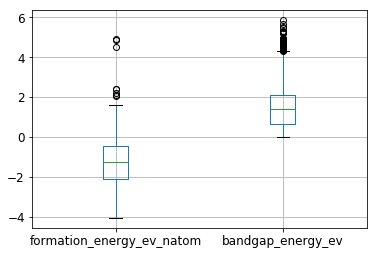

In [5]:
data_complete.boxplot(column = ['formation_energy_ev_natom', 'bandgap_energy_ev'], 
                      fontsize = 12)

In [6]:
# convert plan-text structure data into pymategen.core.Structure 
# object for futher featurization

stru_list = []
for stru in data_complete['structure']:
    lattice_vector,coords, species = read_stru(stru)
    stru = Structure(lattice_vector, species, coords, coords_are_cartesian=False)
    stru_list.append(stru)

data_complete['structure_obj'] = stru_list
data_complete.head(2)

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,structure_obj
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.068,3.4387,"[[1.55234146 7.27713501 6.39632433] Ga, [6.528..."
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.249,2.9210,"[[0. 0. 5.9071715] Al, [ 0. ..."


1. Visualize the summary statsistics of formation energies and bandgaps in complete datasets as well as in each subsets from four sources.

In [7]:
# check the summary statistics of the complete dataset and all the others

print("complete dataset")
data_complete.describe()

complete dataset


,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
count,31543.000000,31543.000000,31543.000000
mean,107.592081,-1.298717,1.440845
std,81.400168,1.029570,0.866672
min,1.000000,-4.053535,0.000000
25%,15.000000,-2.107609,0.665000
50%,99.000000,-1.257404,1.382000
75%,186.000000,-0.459231,2.132000
max,230.000000,4.910340,5.853700


In [8]:
# noticed that formation energy ranges from -4.05 to +4.9 
# and bandgap energy ranges from 0 to 5.85
print("kaggle")
data_k.describe()

kaggle


,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
count,2400.000000,2400.000000,2400.000000
mean,141.517917,0.187614,2.077205
std,84.715548,0.104100,1.006845
min,12.000000,0.000000,0.000100
25%,33.000000,0.105600,1.278500
50%,194.000000,0.181800,1.907850
75%,206.000000,0.256275,2.761950
max,227.000000,0.657200,5.286100


In [9]:
print("materials project")
data_mp.describe()

materials project


,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
count,1284.000000,1284.000000,1284.000000
mean,82.585670,-1.960596,0.901729
std,77.717946,0.876605,1.155783
min,1.000000,-3.955974,0.000000
25%,12.000000,-2.507882,0.000000
50%,62.000000,-1.816382,0.357150
75%,160.000000,-1.426968,1.527650
max,229.000000,2.401276,5.853700


In [10]:
print("icsd")
data_icsd.describe()

icsd


,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
count,9357.000000,9357.000000,9357.000000
mean,87.964305,-1.394988,1.571003
std,73.541002,0.885541,0.780751
min,1.000000,-4.008627,0.122000
25%,14.000000,-2.046327,0.918000
50%,62.000000,-1.303710,1.577000
75%,156.000000,-0.675156,2.230000
max,229.000000,4.489924,3.000000


In [11]:
print("oqmd")
data_oqmd.describe()

oqmd


,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
count,18504.000000,18504.000000,18504.000000
mean,114.851383,-1.360063,1.329831
std,82.286701,3.713958,0.809074
min,1.000000,-4.053535,0.101000
25%,29.000000,-2.215495,0.593000
50%,123.000000,-1.410662,1.225000
75%,216.000000,-0.545360,2.006000
max,230.000000,384.229115,3.000000


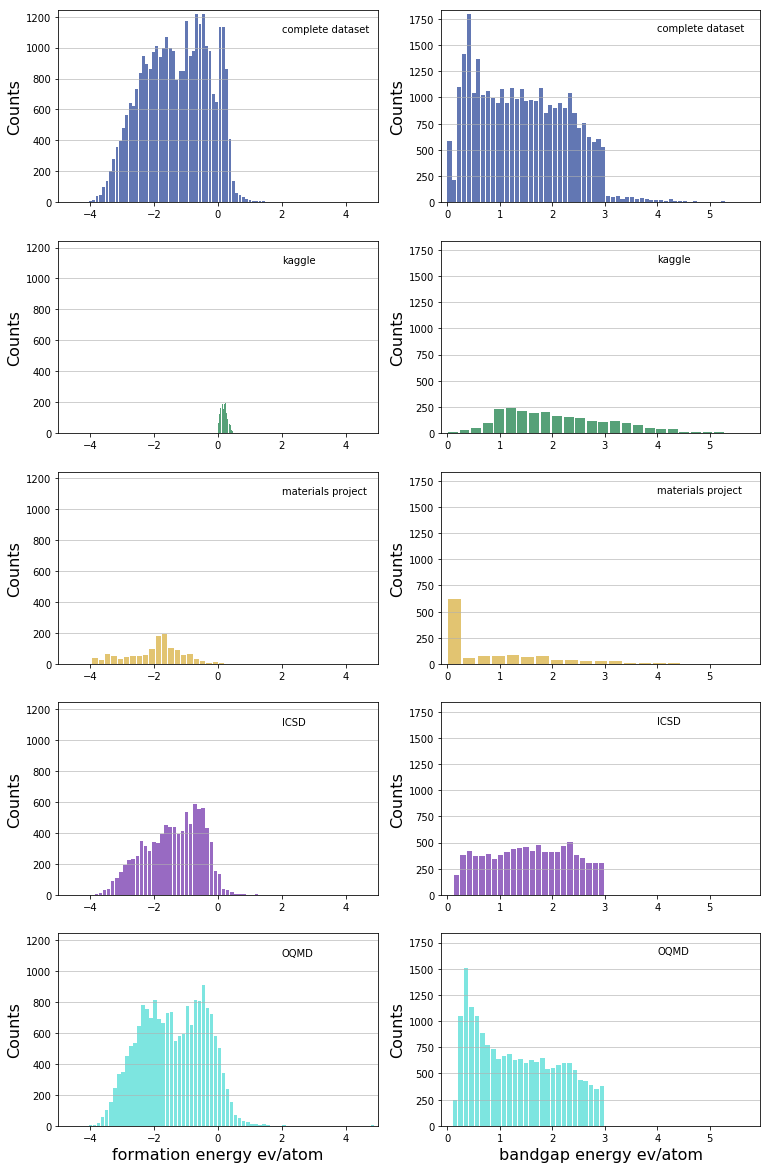

In [12]:
# --------------------- #
#                       #
#    visualization      #
#                       #
# --------------------- #

# set a global fontsize for all the titles and labels of figures 
fontsize = 16

# set legend
legend1 = "complete dataset"
legend2 = "kaggle"
legend3 = 'materials project'
legend4 = "ICSD"
legend5 = "OQMD"

# visualize the distribution of formation energies
ax1 = plt.subplot(5, 2, 1)
ax1.set_xlim([-5, 5])

n, bins, patches = plt.hist(x=data_complete['formation_energy_ev_natom'], 
         bins='auto', color='#1f3e93',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(2,1100,legend1)

# visualize the distribution of bandgaps
ax2 = plt.subplot(5, 2, 2)
n, bins, patches = plt.hist(x=data_complete['bandgap_energy_ev'], 
         bins='auto', color='#1f3e93',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(4,1635,legend1)

# visualize the distribution of formation energies in kaggle dataset
ax3 = plt.subplot(5, 2, 3, sharex=ax1, sharey=ax1)
n, bins, patches = plt.hist(x=data_k['formation_energy_ev_natom'], 
         bins='auto', color='#0f7a3f',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(2,1100,legend2)

# visualize the distribution of bandgaps in kaggle dataset
ax4 = plt.subplot(5, 2, 4,sharex=ax2, sharey=ax2)
n, bins, patches = plt.hist(x=data_k['bandgap_energy_ev'], 
         bins='auto', color='#0f7a3f',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(4,1635,legend2)

# visualize the distribution of formation energies in materials project dataset
ax5 = plt.subplot(5, 2, 5,sharex=ax1, sharey=ax1)
n, bins, patches = plt.hist(x=data_mp['formation_energy_ev_natom'], 
         bins='auto', color='#d6ab35',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(2,1100,legend3)

# visualize the distribution of bandgaps in materials project dataset
ax6 = plt.subplot(5, 2, 6,sharex=ax2, sharey=ax2)
n, bins, patches = plt.hist(x=data_mp['bandgap_energy_ev'], 
         bins='auto', color='#d6ab35',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(4,1635,legend3)

# visualize the distribution of formation energies in icsd dataset
ax7 = plt.subplot(5, 2, 7,sharex=ax1, sharey=ax1)
n, bins, patches = plt.hist(x=data_icsd['formation_energy_ev_natom'], 
         bins='auto', color='#6c2ba8',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(2,1100,legend4)

# visualize the distribution of bandgaps in icsd dataset
ax8 = plt.subplot(5, 2, 8,sharex=ax2, sharey=ax2)
n, bins, patches = plt.hist(x=data_icsd['bandgap_energy_ev'], 
         bins='auto', color='#6c2ba8',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(4,1635,legend4)

# visualize the distribution of formation energies in oqmd dataset
ax9 = plt.subplot(5, 2, 9,sharex=ax1, sharey=ax1)
n, bins, patches = plt.hist(x=data_oqmd['formation_energy_ev_natom'], 
         bins='auto', color='#46dbd3',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('formation energy ev/atom',fontsize = fontsize)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(2,1100,legend5)

# visualize the distribution of bandgaps in oqmd  dataset
ax10 = plt.subplot(5, 2, 10,sharex=ax2, sharey=ax2)
n, bins, patches = plt.hist(x=data_oqmd['bandgap_energy_ev'], 
         bins='auto', color='#46dbd3',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('bandgap energy ev/atom',fontsize = fontsize)
plt.ylabel('Counts',fontsize = fontsize)
plt.margins(0.02)
plt.text(4,1635,legend5)

plt.subplots_adjust(right=1.75, top=4)

Thoughts on point 1: 

We have 31,543(~32K) entries in the complete dataset in which their formation energies ranging from -4.05 to 4.91 eV with the standard deviation of 1.03. The negative formation energy indicates that the formation of a compound is exothermic(the amount of energy it takes to break bonds is less than the amount of energy that is released when making the bonds) while a positive formation energy indicates that the formation of a compound is endothermic(the amount of energy it takes to break bonds is greater than the amount of energy that is released when making the bonds). Formation energy is one of the most important properties of a compound that is directly related to its stability. More negative the formation energy, the more stable the compound is likely to be.[1] Bandgaps in complete dataset range from 0 to 5.87 eV with he standard deviation of 0.87, indicating that the collected materials are either conductors or semiconductors. 


the distribution of bandgaps from kaggle has a bell shape and is close to a normal distribution, while the distribution of bandgaps from materials project has more aound 350/827 entires having bandgap close to 0, which indicates they are conductors.

Based on summary statistics, we have a large enough range of formation energies and positive bangaps as negative value is physically meaningless.

Grouping the complete data based on sources, it has been found that dataset from kaggle repository has positive formation energies from 0 to 0.66 eV with standard deviation of 0.10 eV; positive bandgaps are from 0 to 5.29 eV with the mean of 2.08 eV and standard deviation of 1.0 eV. Formation energies from materials project include negative values and range from -3.95 to 2.4 eV with standard deviation of 0.88 eV. Its bandgaps 0 to 5.85 eV with standard deviation of 1.16 eV. The interesting observation here is that dataset from materials project has ~350/827(~42%) entries with bandgap close to 0 eV, indicating almost a half of the componds collected are conductors.

For datasets from ICSD(Inorganic Crystal Structure Database) has a large range of formation energies(-4.01 to 4.49 eV with standard deviation 0.88 eV) and bandgaps from 0.12 eV up to 3 eV with a standard deviation of 0.78 eV. The clean cutoff of bandgaps at 3 eV is to intentionally have most of the materials in this project to be semicondutors(compounds with an intermediate bandgap), as the project is searching for promising photocatalysts which generates catalytic activity by adsorbing light. This cutoff also applies to data from OQMD(Open Quantum Materials Database) which results in its bandgaps ranging from 1.33 eV to 3 eV.

Anomalies have been detected in the data subset from OQMD. While the minimum formation energy of this dataset seems normal(-4.05 eV), the maximum formation energy shoots up to 384.23 eV. Based on our chemical intuitions, formation energy larger than 5 eV/atom is unreasonable. So we will generate a scatter plot(Figure 2) of formation_energy_ev_natom from OQMD vs. bandgap_energy_ev to locate the anomalies. The scatter plot clearly shows that there are two anomalies. We then take a closer look at these two anomalies by filtering the pandas dataframe(see below) and identify that one anomaly is YbHfO3 having the formation energy of 294.55 eV and the other is YbZrO3 with formation energy of 384.23 eV. These two anomalies are dropped from oqmd and complete datasets for improved data quality.

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
12289,YbHfO3,Full Formula (Yb1 Hf1 O3)\nReduced Formula: Yb...,99,294.545550,0.918
12372,YbZrO3,Full Formula (Yb1 Zr1 O3)\nReduced Formula: Yb...,99,384.229115,0.668


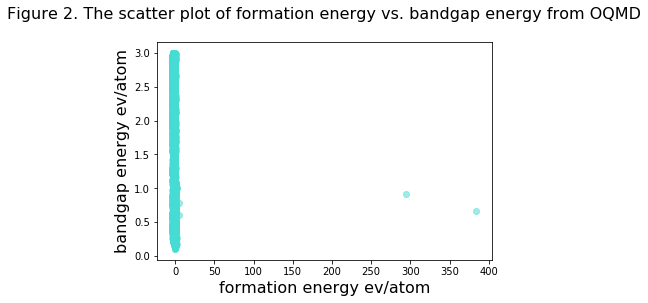

In [13]:
# scatter plot of formation_energy_ev_natom from OQMD vs. bandgap_energy_ev
plt.scatter(data_oqmd['formation_energy_ev_natom'], 
            data_oqmd['bandgap_energy_ev'], 
            c='#46dbd3', alpha=0.5)

plt.xlabel('formation energy ev/atom',fontsize = fontsize)
plt.ylabel('bandgap energy ev/atom',fontsize = fontsize)
plt.title('Figure 2. The scatter plot of formation energy vs. bandgap energy from OQMD\n',
          fontsize = fontsize)

# identify two anomalies

anomalies_oqmd = data_oqmd[data_oqmd['formation_energy_ev_natom'] > 100]
anomalies_oqmd

In [14]:
# drop two anomalies from oqmd and complete datasets
data_oqmd = data_oqmd[data_oqmd['formation_energy_ev_natom'] < 100]
data_complete = data_complete[data_complete['formation_energy_ev_natom'] < 100]

2. Are formation energies and bandgaps two independent targets?

Text(0.5, 1.0, 'The scatter plot of formation energy vs. bandgap energy in the complete dataset\n')

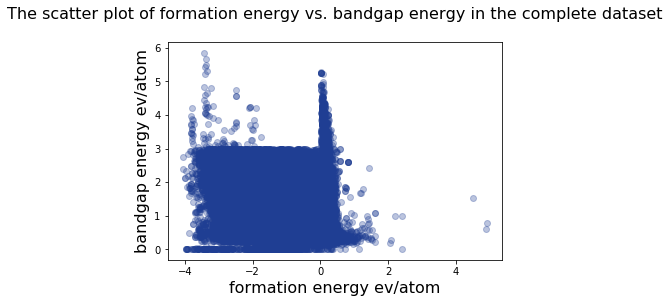

In [15]:
# visualizing the dependence between bandgaps and independent targets
plt.scatter(data_complete['formation_energy_ev_natom'], 
            data_complete['bandgap_energy_ev'], 
            c='#1f3e93', alpha=0.3)

plt.xlabel('formation energy ev/atom',fontsize = fontsize)
plt.ylabel('bandgap energy ev/atom',fontsize = fontsize)
plt.title('The scatter plot of formation energy vs. bandgap energy in the complete dataset\n',
          fontsize = fontsize)

Thoughts on point 2:

The scatter plot of formation energy vs. bandgap energy in the complete dataset shows that there is no obvious relationships between bandgaps and formation energies. Therefore they are independent targets, which means two separate machine learning models are needed to predict there two targets

3. Visualize the Correlation between features

In [16]:
#features
# X_init = data_complete[['formula','structure_obj','spacegroup']]

In [17]:
X_formula_feat = StrToComposition().featurize_dataframe(data_complete, "formula")
X_formula_feat.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,structure_obj,composition
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.0680,3.4387,"[[1.55234146 7.27713501 6.39632433] Ga, [6.528...","(Al, Ga, O)"
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.2490,2.9210,"[[0. 0. 5.9071715] Al, [ 0. ...","(Al, Ga, O)"
2,Al13(GaO8)3,Full Formula (Al13 Ga3 O24)\nReduced Formula: ...,227,0.1821,2.7438,"[[ 8.12426739 0. 13.2219528 ] Ga, [ 4...","(Al, Ga, O)"
3,Al3InO6,Full Formula (Al9 In3 O18)\nReduced Formula: A...,167,0.2172,3.3492,"[[0. 0. 1.96210766] Al, [0. ...","(Al, In, O)"
4,In3Ga5O12,Full Formula (In12 Ga20 O48)\nReduced Formula:...,194,0.0505,1.3793,"[[0. 0. 6.145314] Ga, [ 0. ...","(In, Ga, O)"


In [18]:
# generate formula based features
ep_feat = ElementProperty.from_preset(preset_name="magpie")
# input the "composition" column to the featurizer
X_formula_feat = ep_feat.featurize_dataframe(X_formula_feat, col_id="composition")
X_formula_feat.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,structure_obj,composition,minimum Number,maximum Number,range Number,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.0680,3.4387,"[[1.55234146 7.27713501 6.39632433] Ga, [6.528...","(Al, Ga, O)",8.0,31.0,23.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,73.050,75.97500,12.0
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.2490,2.9210,"[[0. 0. 5.9071715] Al, [ 0. ...","(Al, Ga, O)",8.0,31.0,23.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,73.050,75.97500,12.0
2,Al13(GaO8)3,Full Formula (Al13 Ga3 O24)\nReduced Formula: ...,227,0.1821,2.7438,"[[ 8.12426739 0. 13.2219528 ] Ga, [ 4...","(Al, Ga, O)",8.0,31.0,23.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,85.125,90.91875,12.0
3,Al3InO6,Full Formula (Al9 In3 O18)\nReduced Formula: A...,167,0.2172,3.3492,"[[0. 0. 1.96210766] Al, [0. ...","(Al, In, O)",8.0,49.0,41.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,88.600,91.92000,12.0
4,In3Ga5O12,Full Formula (In12 Ga20 O48)\nReduced Formula:...,194,0.0505,1.3793,"[[0. 0. 6.145314] Ga, [ 0. ...","(In, Ga, O)",8.0,49.0,41.0,...,0.0,0.0,0.0,0.0,12.0,139.0,127.0,44.050,38.46000,12.0


data_source (AbstractData or str): source from which to retrieve
element property data (or use str for preset: “pymatgen”, “magpie”, or “deml”)

In [19]:
# add more formula-based features
X_formula_feat = CompositionToOxidComposition().featurize_dataframe(X_formula_feat, "composition")

os_feat = OxidationStates()
X_formula_feat = os_feat.featurize_dataframe(X_formula_feat, "composition_oxid")
X_formula_feat.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,structure_obj,composition,minimum Number,maximum Number,range Number,...,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.0680,3.4387,"[[1.55234146 7.27713501 6.39632433] Ga, [6.528...","(Al, Ga, O)",8.0,31.0,23.0,...,225.0,213.0,73.050,75.97500,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.287980
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.2490,2.9210,"[[0. 0. 5.9071715] Al, [ 0. ...","(Al, Ga, O)",8.0,31.0,23.0,...,225.0,213.0,73.050,75.97500,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.287980
2,Al13(GaO8)3,Full Formula (Al13 Ga3 O24)\nReduced Formula: ...,227,0.1821,2.7438,"[[ 8.12426739 0. 13.2219528 ] Ga, [ 4...","(Al, Ga, O)",8.0,31.0,23.0,...,225.0,213.0,85.125,90.91875,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.368608
3,Al3InO6,Full Formula (Al9 In3 O18)\nReduced Formula: A...,167,0.2172,3.3492,"[[0. 0. 1.96210766] Al, [0. ...","(Al, In, O)",8.0,49.0,41.0,...,225.0,213.0,88.600,91.92000,12.0,"(Al3+, In3+, O2-)",-2,3,5,3.333333
4,In3Ga5O12,Full Formula (In12 Ga20 O48)\nReduced Formula:...,194,0.0505,1.3793,"[[0. 0. 6.145314] Ga, [ 0. ...","(In, Ga, O)",8.0,49.0,41.0,...,139.0,127.0,44.050,38.46000,12.0,"(In3+, Ga3+, O2-)",-2,3,5,3.287980


In [20]:
# add structure-based features
df_feat = DensityFeatures()
X_formula_stru_feat = df_feat.featurize_dataframe(X_formula_feat, "structure_obj",ignore_errors=True)  
X_formula_stru_feat.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,structure_obj,composition,minimum Number,maximum Number,range Number,...,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,density,vpa,packing fraction
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.0680,3.4387,"[[1.55234146 7.27713501 6.39632433] Ga, [6.528...","(Al, Ga, O)",8.0,31.0,23.0,...,75.97500,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.287980,4.558828,9.763082,0.406490
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.2490,2.9210,"[[0. 0. 5.9071715] Al, [ 0. ...","(Al, Ga, O)",8.0,31.0,23.0,...,75.97500,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.287980,4.550388,9.781192,0.405737
2,Al13(GaO8)3,Full Formula (Al13 Ga3 O24)\nReduced Formula: ...,227,0.1821,2.7438,"[[ 8.12426739 0. 13.2219528 ] Ga, [ 4...","(Al, Ga, O)",8.0,31.0,23.0,...,90.91875,12.0,"(Al3+, Ga3+, O2-)",-2,3,5,3.368608,4.006360,9.780743,0.397922
3,Al3InO6,Full Formula (Al9 In3 O18)\nReduced Formula: A...,167,0.2172,3.3492,"[[0. 0. 1.96210766] Al, [0. ...","(Al, In, O)",8.0,49.0,41.0,...,91.92000,12.0,"(Al3+, In3+, O2-)",-2,3,5,3.333333,4.954174,9.779173,0.465999
4,In3Ga5O12,Full Formula (In12 Ga20 O48)\nReduced Formula:...,194,0.0505,1.3793,"[[0. 0. 6.145314] Ga, [ 0. ...","(In, Ga, O)",8.0,49.0,41.0,...,38.46000,12.0,"(In3+, Ga3+, O2-)",-2,3,5,3.287980,6.222728,11.808966,0.438933


* visualize target value(formation_energy_ev_natom, bandgap_energy_ev) with selective features using scatter plots

In [21]:
X = X_formula_stru_feat.drop(['structure_obj', 'composition'], axis = 1)
X.columns

Index(['formula', 'structure', 'spacegroup', 'formation_energy_ev_natom',
       'bandgap_energy_ev', 'minimum Number', 'maximum Number', 'range Number',
       'mean Number', 'avg_dev Number',
       ...
       'avg_dev SpaceGroupNumber', 'mode SpaceGroupNumber', 'composition_oxid',
       'minimum oxidation state', 'maximum oxidation state',
       'range oxidation state', 'std_dev oxidation state', 'density', 'vpa',
       'packing fraction'],
      dtype='object', length=145)

In [22]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# print out the columns to be dropped
X[to_drop]

,range MendeleevNumber,minimum AtomicWeight,maximum AtomicWeight,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,mean Row,mode Row,range NsValence,...,range NdUnfilled,range NfUnfilled,avg_dev NfUnfilled,range NUnfilled,range GSvolume_pa,range GSbandgap,avg_dev GSbandgap,range GSmagmom,avg_dev GSmagmom,range oxidation state
0,14.0,15.9994,69.723,53.7236,26.803475,12.964890,15.9994,2.550000,2.0,0.0,...,0.0,0.0,0.0,3.0,9.752500,0.000,0.000,0.000000,0.000000,5
1,14.0,15.9994,69.723,53.7236,26.803475,12.964890,15.9994,2.550000,2.0,0.0,...,0.0,0.0,0.0,3.0,9.752500,0.000,0.000,0.000000,0.000000,5
2,14.0,15.9994,69.723,53.7236,23.597865,9.118158,15.9994,2.475000,2.0,0.0,...,0.0,0.0,0.0,3.0,9.752500,0.000,0.000,0.000000,0.000000,5
3,14.0,15.9994,114.818,98.8186,29.175902,17.128420,15.9994,2.600000,2.0,0.0,...,0.0,0.0,0.0,3.0,15.155000,0.000,0.000,0.000000,0.000000,5
4,13.0,15.9994,114.818,98.8186,44.253090,33.904428,15.9994,2.950000,2.0,0.0,...,0.0,0.0,0.0,3.0,15.155000,0.000,0.000,0.000000,0.000000,5
5,14.0,15.9994,69.723,53.7236,27.872011,14.647846,15.9994,2.575000,2.0,0.0,...,0.0,0.0,0.0,3.0,9.752500,0.000,0.000,0.000000,0.000000,5
6,14.0,15.9994,114.818,98.8186,52.737822,44.730013,15.9994,3.137500,2.0,0.0,...,0.0,0.0,0.0,3.0,15.155000,0.000,0.000,0.000000,0.000000,5
7,14.0,15.9994,114.818,98.8186,37.959548,30.743381,15.9994,2.800000,2.0,0.0,...,0.0,0.0,0.0,3.0,15.155000,0.000,0.000,0.000000,0.000000,5
8,14.0,15.9994,114.818,98.8186,32.915779,22.821708,15.9994,2.687500,2.0,0.0,...,0.0,0.0,0.0,3.0,15.155000,0.000,0.000,0.000000,0.000000,5
9,14.0,15.9994,69.723,53.7236,30.543353,18.610333,15.9994,2.637500,2.0,0.0,...,0.0,0.0,0.0,3.0,9.752500,0.000,0.000,0.000000,0.000000,5


In [23]:
# Drop features 
X = X.drop(X[to_drop], axis=1)
# reduce feature from 141 to 118

In [24]:
X

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,...,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,std_dev oxidation state,density,vpa,packing fraction
0,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,33,0.068000,3.4387,8.0,31.0,23.0,12.700,5.640000,...,73.050000,75.975000,12.0,"(Al3+, Ga3+, O2-)",-2,3,3.287980,4.558828,9.763082,0.406490
1,Al5(GaO4)3,Full Formula (Al20 Ga12 O48)\nReduced Formula:...,194,0.249000,2.9210,8.0,31.0,23.0,12.700,5.640000,...,73.050000,75.975000,12.0,"(Al3+, Ga3+, O2-)",-2,3,3.287980,4.550388,9.781192,0.405737
2,Al13(GaO8)3,Full Formula (Al13 Ga3 O24)\nReduced Formula: ...,227,0.182100,2.7438,8.0,31.0,23.0,11.350,4.020000,...,85.125000,90.918750,12.0,"(Al3+, Ga3+, O2-)",-2,3,3.368608,4.006360,9.780743,0.397922
3,Al3InO6,Full Formula (Al9 In3 O18)\nReduced Formula: A...,167,0.217200,3.3492,8.0,49.0,41.0,13.600,7.080000,...,88.600000,91.920000,12.0,"(Al3+, In3+, O2-)",-2,3,3.333333,4.954174,9.779173,0.465999
4,In3Ga5O12,Full Formula (In12 Ga20 O48)\nReduced Formula:...,194,0.050500,1.3793,8.0,49.0,41.0,19.900,14.280000,...,44.050000,38.460000,12.0,"(In3+, Ga3+, O2-)",-2,3,3.287980,6.222728,11.808966,0.438933
5,Al9Ga7O24,Full Formula (Al9 Ga7 O24)\nReduced Formula: A...,227,0.220900,2.1633,8.0,31.0,23.0,13.150,6.247500,...,69.025000,70.188750,12.0,"(Al3+, Ga3+, O2-)",-2,3,3.276928,4.578857,10.107886,0.395150
6,AlIn28(GaO16)3,Full Formula (Al1 In28 Ga3 O48)\nReduced Formu...,206,0.056200,0.9854,8.0,49.0,41.0,23.275,18.586875,...,61.062500,58.875000,12.0,"(Al3+, In3+, Ga3+, O2-)",-2,3,3.410178,6.667312,13.134711,0.491044
7,AlInO3,Full Formula (Al4 In4 O12)\nReduced Formula: A...,12,0.224300,1.7179,8.0,49.0,41.0,17.200,12.720000,...,80.000000,81.600000,12.0,"(Al3+, In3+, O2-)",-2,3,3.273268,5.428753,11.611011,0.456362
8,Al17In8Ga7O48,Full Formula (Al17 In8 Ga7 O48)\nReduced Formu...,206,0.219300,2.6257,8.0,49.0,41.0,15.175,9.534375,...,74.512500,76.854688,12.0,"(Al3+, In3+, Ga3+, O2-)",-2,3,3.224164,5.260337,10.390577,0.447182
9,Al13Ga19O48,Full Formula (Al13 Ga19 O48)\nReduced Formula:...,194,0.199400,2.5187,8.0,31.0,23.0,14.275,7.944375,...,58.962500,56.355000,12.0,"(Al3+, Ga3+, O2-)",-2,3,3.281519,5.037754,10.067667,0.403070


In [25]:
print(X.columns.tolist())

['formula', 'structure', 'spacegroup', 'formation_energy_ev_natom', 'bandgap_energy_ev', 'minimum Number', 'maximum Number', 'range Number', 'mean Number', 'avg_dev Number', 'mode Number', 'minimum MendeleevNumber', 'maximum MendeleevNumber', 'mean MendeleevNumber', 'avg_dev MendeleevNumber', 'mode MendeleevNumber', 'minimum MeltingT', 'maximum MeltingT', 'range MeltingT', 'mean MeltingT', 'avg_dev MeltingT', 'mode MeltingT', 'minimum Column', 'maximum Column', 'range Column', 'mean Column', 'avg_dev Column', 'mode Column', 'minimum Row', 'maximum Row', 'range Row', 'avg_dev Row', 'minimum CovalentRadius', 'maximum CovalentRadius', 'range CovalentRadius', 'mean CovalentRadius', 'avg_dev CovalentRadius', 'mode CovalentRadius', 'minimum Electronegativity', 'maximum Electronegativity', 'range Electronegativity', 'mean Electronegativity', 'avg_dev Electronegativity', 'mode Electronegativity', 'minimum NsValence', 'maximum NsValence', 'mean NsValence', 'avg_dev NsValence', 'mode NsValence',

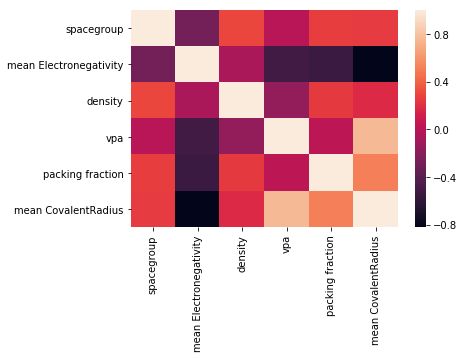

In [26]:
# plot the correlation heatmap for selective features
selective_col = ['spacegroup','mean Electronegativity',
               'density','vpa', 'packing fraction',
               'mean CovalentRadius']
corr = X[selective_col].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

* this corrleation maps for selective features have shown that even after we dropped extremely highly-corrleated feature with its absolute correlation > 0.95, there are still some features that are highly correlated, for example 0.8 negative correlation between mean electronegativity and mean covalent radius, 0.5 negative correlation between mean electronegativity and packing faction. It seems that electronegativity has correlations with serveral features which might be one of the important features for machine learning model. 

* As a next step to do in machine learning, we are going to continue with feature reduction, probably using PCA as I noticed that some of the features is describing the same chemical properties but using various statistics such as mean, maximum, minimum, mode, range etc. In this case we should consider the way of compressing those feature into one, which PCA might help

Text(0, 0.5, 'mean Electronegativity')

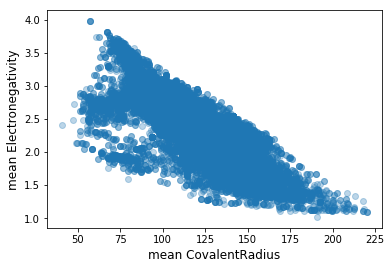

In [27]:
# plot the scatter plot between mean CovalentRadius and mean electronegativity
fontsize = 12
plt.scatter(X['mean CovalentRadius'], X['mean Electronegativity'], alpha = 0.3)
plt.xlabel('mean CovalentRadius',fontsize = fontsize)
plt.ylabel('mean Electronegativity',fontsize = fontsize)

In [28]:
# chi-squared test for statistical significant correlation test
# between mean CovalentRadius and mean electronegativity

from scipy.stats import chi2_contingency


# generate a contingency table
obs = pd.crosstab(X['mean CovalentRadius'], X['mean Electronegativity'])

chi2, p, dof, expected = chi2_contingency(obs)

print (p)

0.0


In [31]:
# save the new complete dataset into a csv
data_complete.to_csv("data_complete_w_features.csv", sep = ',')
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31543 entries, 0 to 18503
Columns: 147 entries, formula to packing fraction
dtypes: float64(138), int64(4), object(5)
memory usage: 35.6+ MB
